# Predict Waist Circumference with Diffusion Weighted Imaging

This notebook using diffusion weighted imaging data, and subjects waist circumference in cm from the ABCD Study.
We will use as input feature derived Restriction spectrum imaging (RSI) from diffusion weighted images. This notebook
covers data loading as well as evaluation across a large number of different ML Pipelines. This notebook may be useful
for people looking for more examples on what different Pipelines to try.

In [1]:
import BPt as bp
import pandas as pd
import os

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Load the data needed

Data is loaded from a large csv file with all of the features from release 2 of the ABCD study.

In [2]:
def load_from_rds(names, eventname='baseline_year_1_arm_1'):
    
    data = pd.read_csv('data/nda_rds_201.csv',
                       usecols=['src_subject_id', 'eventname'] + names,
                       na_values=['777', 999, '999', 777])
    
    data = data.loc[data[data['eventname'] == eventname].index]
    data = data.set_index('src_subject_id')
    data = data.drop('eventname', axis=1)
    
    # Obsificate subject ID for public example
    data.index = list(range(len(data)))
    
    # Return as pandas DataFrame cast to BPt Dataset
    return bp.Dataset(data)

In [3]:
# This way we can look at all column available
all_cols = list(pd.read_csv('data/nda_rds_201.csv', nrows=0))
all_cols[:10]

['subjectid',
 'src_subject_id',
 'eventname',
 'anthro_1_height_in',
 'anthro_2_height_in',
 'anthro_3_height_in',
 'anthro_height_calc',
 'anthro_weight_cast',
 'anthro_weight_a_location',
 'anthro_weight1_lb']

In [4]:
# The target variable
target_cols = ['anthro_waist_cm']

# non input feature - i.e., those that inform 
non_input_cols = ['sex', 'rel_family_id']

# We will use the fiber at dti measures
dti_cols = [c for c in all_cols if '_fiber.at' in c and 'rsi.' in c]
len(dti_cols)

294

Now we can use the helper function defined at the start to load these features in as a Dataset

In [5]:
data = load_from_rds(target_cols + non_input_cols + dti_cols)
data.shape

(11875, 297)

In [6]:
# This is optional, but will print out some extra verbosity when using the dataset operations
data.verbose = 1

The first step we will do is tell the dataset what roles the different columns are. See: https://sahahn.github.io/BPt/user_guide/role.html

In [7]:
data = data.set_target(target_cols) # Note we doing data = data.func()
data = data.set_non_input(non_input_cols)
data

Dropped 2 Rows
Dropped 6 Rows


,dmri_rsi.n0_fiber.at_allfib.lh,dmri_rsi.n0_fiber.at_allfib.rh,dmri_rsi.n0_fiber.at_allfibers,dmri_rsi.n0_fiber.at_allfibnocc.lh,dmri_rsi.n0_fiber.at_allfibnocc.rh,dmri_rsi.n0_fiber.at_atr.lh,dmri_rsi.n0_fiber.at_atr.rh,dmri_rsi.n0_fiber.at_cc,dmri_rsi.n0_fiber.at_cgc.lh,dmri_rsi.n0_fiber.at_cgc.rh,...,dmri_rsi.vol_fiber.at_scs.lh,dmri_rsi.vol_fiber.at_scs.rh,dmri_rsi.vol_fiber.at_sifc.lh,dmri_rsi.vol_fiber.at_sifc.rh,dmri_rsi.vol_fiber.at_slf.lh,dmri_rsi.vol_fiber.at_slf.rh,dmri_rsi.vol_fiber.at_tslf.lh,dmri_rsi.vol_fiber.at_tslf.rh,dmri_rsi.vol_fiber.at_unc.lh,dmri_rsi.vol_fiber.at_unc.rh
0,0.327623,0.323420,0.325957,0.340559,0.332364,0.347837,0.336072,0.306803,0.311347,0.304854,...,23672.0,13056.0,9648.0,9528.0,10152.0,11504.0,8384.0,8024.0,4968.0,7176.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.325374,0.311465,0.319027,0.341213,0.326334,0.346651,0.335362,0.288124,0.326416,0.300990,...,33112.0,19256.0,11928.0,8688.0,13144.0,15344.0,10488.0,10936.0,6904.0,9480.0
3,0.305095,0.304357,0.305170,0.315477,0.312866,0.313972,0.316729,0.288742,0.289166,0.290347,...,28480.0,16016.0,13024.0,11960.0,13600.0,14880.0,11416.0,10592.0,6952.0,8736.0
4,0.316860,0.315238,0.316399,0.328251,0.327259,0.333998,0.318162,0.294008,0.297800,0.299230,...,29904.0,17968.0,12720.0,11336.0,13528.0,15672.0,11096.0,11816.0,5912.0,7336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,0.335741,0.336048,0.336372,0.349806,0.347732,0.349966,0.345692,0.312056,0.324054,0.336676,...,28328.0,15400.0,9656.0,10080.0,11312.0,13496.0,8728.0,9176.0,4960.0,7392.0
11871,0.320563,0.317525,0.319429,0.327302,0.322161,0.333086,0.315482,0.308554,0.299938,0.298093,...,23792.0,13632.0,9928.0,8912.0,9152.0,12288.0,7128.0,8912.0,5744.0,7376.0
11872,0.327051,0.325386,0.326522,0.340918,0.334854,0.345435,0.335610,0.305720,0.308630,0.330612,...,28640.0,16384.0,9496.0,11216.0,12168.0,12312.0,9520.0,8952.0,4568.0,9056.0
11873,0.323579,0.319377,0.321805,0.334945,0.329433,0.332200,0.334017,0.304399,0.303831,0.307037,...,26216.0,14672.0,9408.0,8872.0,10960.0,12584.0,8880.0,9176.0,3696.0,6168.0


A few things to note right off the bat.

1. The verbosity printed us out two statements, about dropping rows. This is due to a constraint on columns of role 'non input' that there cannot be any NaN / missing data, so those lines just say 2 NaN's were found when loading the first non input column and 6 when loading the next.

2. The values for sex are still 'F' and 'M', we will handle that next.

3. Some columns with role data are missing values. We will handle that as well.

In [8]:
# We explicitly say this variable should be binary
data.to_binary('sex', inplace=True)

# We will ordinalize rel_family_id too
data = data.ordinalize(scope='rel_family_id')

data['non input']

,rel_family_id,sex
0,7321,0
1,8634,0
2,3971,1
3,3139,1
4,4543,1
...,...,...
11870,3128,1
11871,2111,0
11872,5907,0
11873,5594,0


Next let's look into that NaN problem we saw before.

In [9]:
data.nan_info()

Loaded NaN Info:
There are: 332348 total missing values
180 columns found with 1131 missing values (column name overlap: ['dmri_rsi.n', '_fiber.at_'])
66 columns found with 1130 missing values (column name overlap: ['dmri_rsi.n', '_fiber.at_'])
42 columns found with 1128 missing values (column name overlap: ['dmri_rsi.vol_fiber.at_'])
6 columns found with 1133 missing values (column name overlap: ['_fiber.at_cgh.lh', 'dmri_rsi.n'])



Seems like most of the missing data is missing for everyone, i.e., if the above info founds columns with only a few missing values, we might want to do something different, but this tells us that when data is missing it is missing for all columns.

We just drop any subjects with any NaN data below across the target variable and the Data

In [10]:
data = data.drop_nan_subjects(scope='all')

Dropped 1145 Rows


Another thing we need to worry about with data like this is corrupted data, i.e., data with values that don't make sense due to a failure in the automatic processing pipeline. Let's look at the target variable first, then the data.

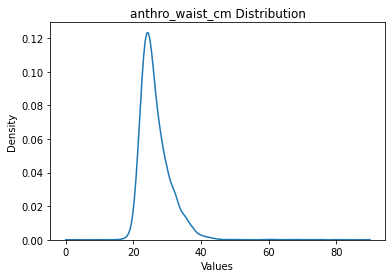

(anthro_waist_cm    90.0
 dtype: float64,
 anthro_waist_cm    0.0
 dtype: float64)

In [11]:
data.plot('target')
data['target'].max(), data['target'].min(),

Yeah I don't know about that waist cm of 0 ...
The below code can be used to try different values of outliers to drop, since it is not by default applied in place.

Dropped 33 Rows


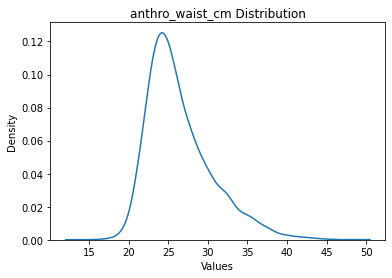

In [12]:
data.filter_outliers_by_std(scope='target', n_std=5).plot('target')

5 std seems okay, so let's actually apply it.

In [13]:
data.filter_outliers_by_std(scope='target', n_std=5, inplace=True)

Dropped 33 Rows


Let's look at the distribution of skew values for the dti data

In [14]:
data['data'].skew().sort_values()

dmri_rsi.nd_fiber.at_fmaj       -2.420074
dmri_rsi.nds2_fiber.at_fmaj     -2.287048
dmri_rsi.nd_fiber.at_cst.lh     -2.213900
dmri_rsi.nt_fiber.at_cst.lh     -2.198591
dmri_rsi.nds2_fiber.at_fmin     -2.101969
                                   ...   
dmri_rsi.nts2_fiber.at_cst.rh    0.992159
dmri_rsi.n0s2_fiber.at_fmin      1.005677
dmri_rsi.nts2_fiber.at_fmin      1.006378
dmri_rsi.n0s2_fiber.at_cst.lh    1.072836
dmri_rsi.nts2_fiber.at_cst.lh    1.090904
Length: 294, dtype: float64

Looks okay, let's choose the variable with the most extreme skew to plot.

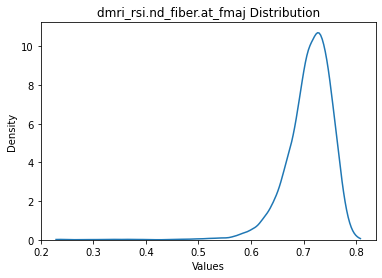

In [15]:
data.plot(scope='dmri_rsi.nd_fiber.at_fmaj')

How about we apply just a strict criteria of say 10 std.

In [16]:
data.filter_outliers_by_std(scope='data', n_std=10, inplace=True)

Dropped 26 Rows


## Define a Test set. 

In this example project we are going to test a bunch of different Machine Learning Pipeline's. In order to avoid meta-issues of overfitting onto our dataset, we will therefore define a train-test split. The train set we will use to try different pipelines, then only with the best final pipeline will we use the test set. 

We will impose one extra constraint when applying the test split, namely that members of the same family, i.e., those with the same family id, stay in the same training or testing fold.

In [17]:
# We use this to say we want to preserve families
preserve_family = bp.CVStrategy(groups='rel_family_id')

# Apply the test split
data = data.set_test_split(size=.2,
                           cv_strategy=preserve_family,
                           random_state=6)

data

Performing test split on: 10663 subjects.
random_state: 6
Test split size: 0.2

Performed train/test split
Train size: 8562
Test size:  2101


,dmri_rsi.n0_fiber.at_allfib.lh,dmri_rsi.n0_fiber.at_allfib.rh,dmri_rsi.n0_fiber.at_allfibers,dmri_rsi.n0_fiber.at_allfibnocc.lh,dmri_rsi.n0_fiber.at_allfibnocc.rh,dmri_rsi.n0_fiber.at_atr.lh,dmri_rsi.n0_fiber.at_atr.rh,dmri_rsi.n0_fiber.at_cc,dmri_rsi.n0_fiber.at_cgc.lh,dmri_rsi.n0_fiber.at_cgc.rh,...,dmri_rsi.vol_fiber.at_scs.lh,dmri_rsi.vol_fiber.at_scs.rh,dmri_rsi.vol_fiber.at_sifc.lh,dmri_rsi.vol_fiber.at_sifc.rh,dmri_rsi.vol_fiber.at_slf.lh,dmri_rsi.vol_fiber.at_slf.rh,dmri_rsi.vol_fiber.at_tslf.lh,dmri_rsi.vol_fiber.at_tslf.rh,dmri_rsi.vol_fiber.at_unc.lh,dmri_rsi.vol_fiber.at_unc.rh
0,0.327623,0.323420,0.325957,0.340559,0.332364,0.347837,0.336072,0.306803,0.311347,0.304854,...,23672.0,13056.0,9648.0,9528.0,10152.0,11504.0,8384.0,8024.0,4968.0,7176.0
2,0.325374,0.311465,0.319027,0.341213,0.326334,0.346651,0.335362,0.288124,0.326416,0.300990,...,33112.0,19256.0,11928.0,8688.0,13144.0,15344.0,10488.0,10936.0,6904.0,9480.0
3,0.305095,0.304357,0.305170,0.315477,0.312866,0.313972,0.316729,0.288742,0.289166,0.290347,...,28480.0,16016.0,13024.0,11960.0,13600.0,14880.0,11416.0,10592.0,6952.0,8736.0
4,0.316860,0.315238,0.316399,0.328251,0.327259,0.333998,0.318162,0.294008,0.297800,0.299230,...,29904.0,17968.0,12720.0,11336.0,13528.0,15672.0,11096.0,11816.0,5912.0,7336.0
5,0.323521,0.326741,0.325466,0.336003,0.335291,0.326243,0.337367,0.305382,0.311843,0.315721,...,23048.0,12032.0,9056.0,9248.0,9672.0,11048.0,7848.0,7520.0,5088.0,7448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,0.335741,0.336048,0.336372,0.349806,0.347732,0.349966,0.345692,0.312056,0.324054,0.336676,...,28328.0,15400.0,9656.0,10080.0,11312.0,13496.0,8728.0,9176.0,4960.0,7392.0
11871,0.320563,0.317525,0.319429,0.327302,0.322161,0.333086,0.315482,0.308554,0.299938,0.298093,...,23792.0,13632.0,9928.0,8912.0,9152.0,12288.0,7128.0,8912.0,5744.0,7376.0
11872,0.327051,0.325386,0.326522,0.340918,0.334854,0.345435,0.335610,0.305720,0.308630,0.330612,...,28640.0,16384.0,9496.0,11216.0,12168.0,12312.0,9520.0,8952.0,4568.0,9056.0
11873,0.323579,0.319377,0.321805,0.334945,0.329433,0.332200,0.334017,0.304399,0.303831,0.307037,...,26216.0,14672.0,9408.0,8872.0,10960.0,12584.0,8880.0,9176.0,3696.0,6168.0


## Evaluate Different Pipelines

First let's save some commonly used parameters in an object called the ProblemSpec, we will use all defaults except for the number of jobs, for that let's use n_jobs=8.

In [18]:
ps = bp.ProblemSpec(n_jobs=8)

The function we will use to evaluate different pipelines is bp.evaluate, let's start with an example with just a linear regression model.

In [19]:
linear_model = bp.Model('linear')

results = bp.evaluate(pipeline=linear_model,
                      dataset=data,
                      problem_spec=ps,
                      eval_verbose=1)
results

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 4.1 seconds.
explained_variance: 0.1923
neg_mean_squared_error: -14.43

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 2.1 seconds.
explained_variance: 0.2114
neg_mean_squared_error: -13.96

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 1.4 seconds.
explained_variance: 0.1919
neg_mean_squared_error: -14.00

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 1.0 seconds.
explained_variance: 0.1610
neg_mean_squared_error: -13.92

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 1.7 seconds.
explained_variance: 0.2145
neg_mean_squared_error: -13.57



EvalResults
------------
explained_variance: 0.1942 ± 0.0191
neg_mean_squared_error: -13.97 ± 0.2730

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


Note from the verbose output that it has correctly detected a number of things including: a regression problem type, that we only want to use the training set, that we want to use all input features, what the target variable is, ect...

We get an instance of BPtEvaluator with the results. This stores all kinds of different information, for example:

In [20]:
# Beta weights
results.get_fis()

,dmri_rsi.n0_fiber.at_allfib.lh,dmri_rsi.n0_fiber.at_allfib.rh,dmri_rsi.n0_fiber.at_allfibers,dmri_rsi.n0_fiber.at_allfibnocc.lh,dmri_rsi.n0_fiber.at_allfibnocc.rh,dmri_rsi.n0_fiber.at_atr.lh,dmri_rsi.n0_fiber.at_atr.rh,dmri_rsi.n0_fiber.at_cc,dmri_rsi.n0_fiber.at_cgc.lh,dmri_rsi.n0_fiber.at_cgc.rh,...,dmri_rsi.vol_fiber.at_scs.lh,dmri_rsi.vol_fiber.at_scs.rh,dmri_rsi.vol_fiber.at_sifc.lh,dmri_rsi.vol_fiber.at_sifc.rh,dmri_rsi.vol_fiber.at_slf.lh,dmri_rsi.vol_fiber.at_slf.rh,dmri_rsi.vol_fiber.at_tslf.lh,dmri_rsi.vol_fiber.at_tslf.rh,dmri_rsi.vol_fiber.at_unc.lh,dmri_rsi.vol_fiber.at_unc.rh
0,13.658717,10.182917,11.113703,2.741103,2.096137,0.652331,-19.689333,18.133593,6.170156,18.584436,...,0.000343,-0.000589,0.000551,0.000348,-0.000216,0.000278,1.902580e-04,-0.000544,0.000643,0.000572
1,13.386769,-7.807120,5.590872,2.074826,1.611921,-5.200155,-17.350840,18.954327,4.418044,18.556810,...,0.000263,-0.000505,0.000523,0.000272,-0.000371,0.000474,1.721382e-04,-0.000582,0.000530,0.000525
2,14.601005,6.447403,6.566593,5.105803,2.144557,-0.249971,-17.505516,19.815592,10.121972,15.690188,...,0.000319,-0.000600,0.000455,0.000446,-0.000303,0.000618,1.192093e-07,-0.000615,0.000378,0.000662
3,12.660464,16.193197,-0.193520,2.184492,3.968235,-7.643031,-16.103781,15.539372,9.867133,14.523899,...,0.000341,-0.000441,0.000587,0.000453,-0.000284,0.000608,1.287460e-04,-0.000701,0.000359,0.000616
4,16.212349,11.518905,7.905156,6.085897,1.294112,-8.058172,-11.786942,13.227197,10.812229,12.374775,...,0.000080,-0.000515,0.000614,0.000411,-0.000342,0.000784,2.737045e-04,-0.000738,0.000555,0.000540


In [21]:
# Raw predictions made from each fold
results.get_preds_dfs()[0]

,predict,y_true
28,24.345831,21.25
33,24.806902,24.50
36,26.968584,23.00
40,27.805948,30.80
47,25.691679,20.00
...,...,...
11848,28.006598,25.50
11851,23.925535,24.00
11855,30.389441,38.80
11861,25.687613,26.00


All options are listed under: 'Saved Attributes' and 'Available Methods'.

Anyways, let's continue trying different models. We will use a ridge regression model. Let's also use the fact that the jupyter notebook is defining variables in global scope to clean up the evaluation code a bit so we don't have to keep copy and pasting it.

In [22]:
def eval_pipe(pipeline, **kwargs):
    return bp.evaluate(pipeline=pipeline,
                       dataset=data,
                       problem_spec=ps,
                       **kwargs)

In [23]:
ridge_model = bp.Model('ridge')

# Add standard scaler before ridge model
# We want this because the same amount of regularization is used across features
ridge_pipe = bp.Pipeline([bp.Scaler('standard'), ridge_model])

eval_pipe(ridge_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 0.5 seconds.
explained_variance: 0.2318
neg_mean_squared_error: -13.70

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 0.8 seconds.
explained_variance: 0.2235
neg_mean_squared_error: -13.75

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 0.8 seconds.
explained_variance: 0.2298
neg_mean_squared_error: -13.34

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 0.7 seconds.
explained_variance: 0.1962
neg_mean_squared_error: -13.31

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 0.9 seconds.
explained_variance: 0.2625
neg_mean_squared_error: -12.74



EvalResults
------------
explained_variance: 0.2287 ± 0.0212
neg_mean_squared_error: -13.37 ± 0.3624

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


The ridge regression has hyper-parameters though, what if just whatever the default value is, is not a good choice? We can add a parameter search to the model object.

In [24]:
random_search = bp.ParamSearch('RandomSearch', n_iter=64)

ridge_search_model = bp.Model('ridge',
                              params=1, # Referring to a preset distribution of hyper-params
                              param_search=random_search)

ridge_search_pipe = bp.Pipeline([bp.Scaler('standard'), ridge_search_model])
    
eval_pipe(ridge_search_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 30.9 seconds.
explained_variance: 0.2317
neg_mean_squared_error: -13.70

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 20.2 seconds.
explained_variance: 0.2206
neg_mean_squared_error: -13.81

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 18.9 seconds.
explained_variance: 0.2321
neg_mean_squared_error: -13.30

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 14.9 seconds.
explained_variance: 0.1966
neg_mean_squared_error: -13.30

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 12.6 seconds.
explained_variance: 0.2585
neg_mean_squared_error: -12.81



EvalResults
------------
explained_variance: 0.2279 ± 0.0200
neg_mean_squared_error: -13.38 ± 0.3527

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


At any point we can also ask different questions, for example: What happens we evaluate the model on only one sex?

In [25]:
# Male only model first
eval_pipe(ridge_search_pipe,
          subjects=bp.ValueSubset('sex', 'M', decode_values=True))

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 5546 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (4436, 294)
Validation Set: (1110, 294)
Fit fold in 9.3 seconds.
explained_variance: 0.2265
neg_mean_squared_error: -13.28

Training Set: (4437, 294)
Validation Set: (1109, 294)
Fit fold in 9.3 seconds.
explained_variance: 0.1731
neg_mean_squared_error: -13.31

Training Set: (4437, 294)
Validation Set: (1109, 294)
Fit fold in 8.4 seconds.
explained_variance: 0.2346
neg_mean_squared_error: -13.84

Training Set: (4437, 294)
Validation Set: (1109, 294)
Fit fold in 9.3 seconds.
explained_variance: 0.1924
neg_mean_squared_error: -13.05

Training Set: (4437, 294)
Validation Set: (1109, 294)
Fit fold in 10.2 seconds.
explained_variance: 0.2864
neg_mean_squared_error: -13.12



EvalResults
------------
explained_variance: 0.2226 ± 0.0390
neg_mean_squared_error: -13.32 ± 0.2764

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: ValueSubset(name=sex, values=M, decode_values=True)
random_state: 1
n_jobs: 8


In [26]:
eval_pipe(ridge_search_pipe,
          subjects=bp.ValueSubset('sex', 'F', decode_values=True))

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 5117 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (4093, 294)
Validation Set: (1024, 294)
Fit fold in 15.1 seconds.
explained_variance: 0.2763
neg_mean_squared_error: -13.50

Training Set: (4093, 294)
Validation Set: (1024, 294)
Fit fold in 17.2 seconds.
explained_variance: 0.2012
neg_mean_squared_error: -13.97

Training Set: (4094, 294)
Validation Set: (1023, 294)
Fit fold in 20.9 seconds.
explained_variance: 0.2244
neg_mean_squared_error: -13.38

Training Set: (4094, 294)
Validation Set: (1023, 294)
Fit fold in 17.4 seconds.
explained_variance: 0.2349
neg_mean_squared_error: -15.06

Training Set: (4094, 294)
Validation Set: (1023, 294)
Fit fold in 13.8 seconds.
explained_variance: 0.2300
neg_mean_squared_error: -13.97



EvalResults
------------
explained_variance: 0.2334 ± 0.0244
neg_mean_squared_error: -13.97 ± 0.5936

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: ValueSubset(name=sex, values=F, decode_values=True)
random_state: 1
n_jobs: 8


We do see a decrease in performance for the male model, though it is a bit difficult to tell if that is just noise, or related to the smaller sample sizes. Atleast the results are close, which tells us that sex likely is not being exploited as a proxy! For example if we ran the two same sex only models and they did terrible, it would tell us that our original model had been just memorizing sex effects.

Let's try a different choice of scaler next.

In [27]:
ridge_search_pipe = bp.Pipeline([bp.Scaler('robust'), ridge_search_model])
eval_pipe(ridge_search_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 20.5 seconds.
explained_variance: 0.2314
neg_mean_squared_error: -13.70

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 19.8 seconds.
explained_variance: 0.2233
neg_mean_squared_error: -13.76

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 17.2 seconds.
explained_variance: 0.2362
neg_mean_squared_error: -13.23

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 19.6 seconds.
explained_variance: 0.1923
neg_mean_squared_error: -13.37

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 20.1 seconds.
explained_variance: 0.2590
neg_mean_squared_error: -12.80



EvalResults
------------
explained_variance: 0.2285 ± 0.0216
neg_mean_squared_error: -13.37 ± 0.3482

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


In [28]:
ridge_search_pipe = bp.Pipeline([bp.Scaler('quantile norm'), ridge_search_model])
eval_pipe(ridge_search_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 25.7 seconds.
explained_variance: 0.2372
neg_mean_squared_error: -13.61

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 23.1 seconds.
explained_variance: 0.2494
neg_mean_squared_error: -13.30

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 20.3 seconds.
explained_variance: 0.2463
neg_mean_squared_error: -13.05

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 23.7 seconds.
explained_variance: 0.2250
neg_mean_squared_error: -12.83

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 21.7 seconds.
explained_variance: 0.2640
neg_mean_squared_error: -12.72



EvalResults
------------
explained_variance: 0.2444 ± 0.0130
neg_mean_squared_error: -13.10 ± 0.3219

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


Okay so far we arn't really seeing sweeping differences when any of the parameters are changed, what about if we try some different complete models as well? Let's also start off by using some full default pipelines. We can see options with:

In [29]:
from BPt.default.pipelines import pipelines
list(pipelines)

['elastic_pipe',
 'ridge_pipe',
 'rf_pipe',
 'gb_pipe',
 'svm_pipe',
 'svm_fs_pipe',
 'stacking_pipe',
 'compare_pipe']

Let's try the elastic net first.

In [30]:
from BPt.default.pipelines import elastic_pipe
elastic_pipe

Pipeline(steps=[Imputer(obj='mean', scope='float'),
                Imputer(obj='median', scope='category'), Scaler(obj='robust'),
                Transformer(obj='one hot encoder', scope='category'),
                Model(obj='elastic',
                      param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                               n_iter=60),
                      params=1)])

We can see that this object has imputation and also a one hot enocer for categorical variables built in. In our case those will just be skipped.

In [31]:
eval_pipe(elastic_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 16.0 seconds.
explained_variance: 0.2295
neg_mean_squared_error: -13.74

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 16.7 seconds.
explained_variance: 0.2239
neg_mean_squared_error: -13.75

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 15.5 seconds.
explained_variance: 0.2330
neg_mean_squared_error: -13.28

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 16.1 seconds.
explained_variance: 0.1972
neg_mean_squared_error: -13.29

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 16.4 seconds.
explained_variance: 0.2593
neg_mean_squared_error: -12.79



EvalResults
------------
explained_variance: 0.2286 ± 0.0198
neg_mean_squared_error: -13.37 ± 0.3542

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


Let's try a light gbm model next

In [32]:
from BPt.default.pipelines import gb_pipe
eval_pipe(gb_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 138.6 seconds.
explained_variance: 0.1610
neg_mean_squared_error: -15.00

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 170.9 seconds.
explained_variance: 0.1709
neg_mean_squared_error: -14.68

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 114.8 seconds.
explained_variance: 0.1710
neg_mean_squared_error: -14.36

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 168.0 seconds.
explained_variance: 0.1370
neg_mean_squared_error: -14.31

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 164.0 seconds.
explained_variance: 0.1642
neg_mean_squared_error: -14.43



EvalResults
------------
explained_variance: 0.1608 ± 0.0125
neg_mean_squared_error: -14.56 ± 0.2542

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'feature_importances_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_feature_importances', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


non-linear svm?

In [33]:
from BPt.default.pipelines import svm_pipe
eval_pipe(svm_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 1317.3 seconds.
explained_variance: 0.2625
neg_mean_squared_error: -13.51

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 1662.7 seconds.
explained_variance: 0.2699
neg_mean_squared_error: -12.96

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 1538.4 seconds.
explained_variance: 0.2708
neg_mean_squared_error: -12.79

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 1573.4 seconds.
explained_variance: 0.2280
neg_mean_squared_error: -12.83

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 1875.5 seconds.
explained_variance: 0.3060
neg_mean_squared_error: -12.22



EvalResults
------------
explained_variance: 0.2674 ± 0.0248
neg_mean_squared_error: -12.86 ± 0.4109

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


How about a linear svm?

In [34]:
sgd_pipe = bp.Pipeline([bp.Scaler('robust'),
                        bp.Model('linear svm', params=1, param_search=random_search)])
eval_pipe(sgd_pipe)

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 3274.4 seconds.
explained_variance: 0.2487
neg_mean_squared_error: -13.82

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 885.4 seconds.
explained_variance: 0.2184
neg_mean_squared_error: -13.92

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 863.3 seconds.
explained_variance: 0.2373
neg_mean_squared_error: -13.39

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 877.8 seconds.
explained_variance: 0.2149
neg_mean_squared_error: -13.09

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 885.8 seconds.
explained_variance: 0.2588
neg_mean_squared_error: -13.26



EvalResults
------------
explained_variance: 0.2356 ± 0.0170
neg_mean_squared_error: -13.49 ± 0.3224

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: train
random_state: 1
n_jobs: 8


## Compare

We can also notably achieve a lot of the different modelling steps we just took, but in a much cleaner way, that is through special Compare input objects. For example let's run the comparisons between a few models. Compare basically does a grid search over all of the parameters, but in contrast to setting up the different options as a nested grid search, the full 5-fold CV is run for every combination.

In [35]:
# Define a set of bp.Options as wrapped in bp.Compare
compare_pipes = bp.Compare([bp.Option(sgd_pipe, name='sgd'),
                            bp.Option(ridge_search_pipe, name='ridge'),
                            bp.Option(elastic_pipe, name='elastic'),
                            bp.Option(gb_pipe, name='gb')])

# Pass as before as if a pipeline
results = eval_pipe(compare_pipes)
results.summary()

Running Compare: Options(pipeline=sgd)
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.


Compare:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 863.6 seconds.
explained_variance: 0.2487
neg_mean_squared_error: -13.82

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 865.4 seconds.
explained_variance: 0.2184
neg_mean_squared_error: -13.92

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 864.7 seconds.
explained_variance: 0.2373
neg_mean_squared_error: -13.39

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 878.7 seconds.
explained_variance: 0.2149
neg_mean_squared_error: -13.09

Training Set: (6850, 294)
Validation Set: (1712, 294)
Fit fold in 887.9 seconds.
explained_variance: 0.2588
neg_mean_squared_error: -13.26

Running Compare: Options(pipeline=ridge)
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 8562 total data points.

Training Set: (6849, 294)
Validation Set: (1713, 294)
Fit fold in 10.5 seconds.
explained_variance: 

,mean_scores_explained_variance,mean_scores_neg_mean_squared_error,std_scores_explained_variance,std_scores_neg_mean_squared_error
pipeline,,,,
sgd,0.235641,-13.494077,0.016977,0.322444
ridge,0.244405,-13.102760,0.012968,0.321893
elastic,0.228586,-13.372265,0.019836,0.354189
gb,0.160839,-14.556772,0.012517,0.254181


## Applying the Test Set

So far we have been only running internal 5-fold CV on the training set. What if we say we are done with exploration, and now we want to essentially confirm that our best model we have found through internal CV on the training set generalizes to a set of unseen data. To do this, we re-train the best model tested on the full training set and test it on the testing set. In BPt this is done by just passing cv='test' to evaluate. 

In [36]:
results = eval_pipe(ridge_search_pipe, cv='test', eval_verbose=1)
results

Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 294 features).
Evaluating 10663 total data points.


Folds:   0%|          | 0/1 [00:00<?, ?it/s]


Training Set: (8562, 294)
Validation Set: (2101, 294)
Fit fold in 12.5 seconds.
explained_variance: 0.2693
neg_mean_squared_error: -13.93



EvalResults
------------
explained_variance: 0.2693 ± 0.0000
neg_mean_squared_error: -13.93 ± 0.0000

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: anthro_waist_cm
problem_type: regression
scope: all
subjects: all
random_state: 1
n_jobs: 8
